In [47]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima import model_selection
import statsmodels
from pmdarima.pipeline import Pipeline
from pmdarima import preprocessing
from pmdarima import arima
from datetime import datetime
import pickle
import glob

In [48]:
def mape(preds, labels):
    err = 0
    for (pred, label) in zip(preds, labels):
        denum = np.absolute(label) if label !=0 else 100 # this might be wrong
        err += (np.absolute(pred-label) / denum)
    err /= preds.shape[0]
    print("MAPE - {}".format(err))
    return err
    
# Brier Score or Mean Squared Error
def mse(preds, labels):
    err = np.sum(np.power(preds-labels, 2)) / preds.shape[0]
    print("MSE - {}".format(err))
    return err

def mae(preds, labels):
    err = np.sum(np.abs(preds-labels)) / preds.shape[0]
    print("MAE - {}".format(err))
    return err
    
# Root Mean Squared Error
def rmse(preds, labels):
    err = np.power(mse(preds, labels), 0.5)
    print("RMSE - {}".format(err))
    return err

def calculate_errors(preds, labels):
    return [fn(preds, labels) for fn in [mae, rmse, mape]]


In [ ]:
freq = 20
seasonality = (24 * 60) // freq
split = 0.8
p, d, q= (1,0,1)
P, D, Q = (3, 0, 3)

models = {}
filenames = glob.glob('samples/*.csv')
datasets = [filename.split('/')[1].split('.')[0] for filename in filenames]
#datasets = ['WI','KY', 'ND', 'CA', 'DE', 'OK', 'NE', 'MD', 'ID', 'WV', 'NC','WY', 'VT', 'IA']
print(datasets)
columns = ['MAE','RMSE', 'MAPE', '3pt MAE','3pt RMSE','3pt MAPE', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_MAPE', '3pt MEAN MAE','3pt MEAN RMSE','3pt MEAN MAPE', 'NAIVE_MAE', 'NAIVE_RMSE', 'NAIVE_MAE', '3pt NAIVE MAE','3pt NAIVE RMSE','3pt NAIVE MAPE']
df = pd.DataFrame(columns = columns, dtype=np.float64)
for dataset in datasets:
    # Generates train and test sets 
    data = pd.read_csv('samples/' + dataset + '.csv', delimiter=',', index_col=0, parse_dates=True)
    downsampled = data.resample(str(freq) + 'T').mean()
    raw_values = np.asarray(downsampled['CpuUtilizationAverage'])
    train_frac = '2_3'
    tsize = math.floor(raw_values.shape[0] * split)
    train, test = model_selection.train_test_split(raw_values, train_size=tsize)

    #Calculate Naive Values
    mean = train.mean()
    mean_forecasts = np.ones(test.shape[0]) * mean
    naive_forecasts = np.ones(test.shape[0]) * train[-1]
    
    # Train ARIMA models
    start = datetime.now()
    model = arima.ARIMA((p,d,q), (P,D,Q,seasonality), method='powell')
    model.fit(train)
    end = datetime.now()
    print(f"Trained {dataset} in " + str(end - start))
    
    # Save models to disk
    filename = f"./models/{dataset}.arima"
    pickle.dump(model, open( filename, "wb" ))
    
    # Predict future
    model_forecasts = model.predict(test.shape[0])
    
    # Create plot of forecasts
    x = np.arange(train.shape[0] + test.shape[0])
    plt.clf()
    plt.plot(x[:train.shape[0]], train, c='blue')
    plt.plot(x[train.shape[0]:], model_forecasts, c='green')
    plt.plot(x[train.shape[0]:], raw_values[tsize:], c='blue', alpha=0.3)
    plt.xlabel('Time (Days)')
    plt.ylabel('CPU Usage')
    ticks = np.arange(0, raw_values.shape[0], seasonality)
    tick_labels = [str(label) for label in ticks // seasonality]
    ax = plt.gca()
    plt.xticks(ticks)
    ax.set_xticklabels(tick_labels)
    #plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor='w', edgecolor='k')
    plt.draw()
    plotname = f"./arima_plots/{dataset}.png"
    plt.savefig(plotname, format='png')

    # Calculate Errors
    errors = []
    
    for forecast in [model_forecasts, mean_forecasts, naive_forecasts]:
        errors.extend(calculate_errors(forecast, test))
        errors.extend(calculate_errors(forecast[:3], test[:3]))

     
    row = pd.DataFrame([errors], index=[dataset], columns = columns, dtype=np.float64 )
    df = pd.concat([row, df])

df.to_csv("arima_results.csv")

WI
MAE - 3.645871544672585
MSE - 22.228415677920133
RMSE - 4.71470207732367
MAPE - 0.28588251540502047
MAE - 1.88936186787749
MSE - 5.650042155237927
RMSE - 2.376981732205346
MAPE - 0.06142611442968612
MAE - 9.832769097222224
MSE - 131.21854342488106
RMSE - 11.455066277629347
MAPE - 0.8766374567032356
MAE - 5.342650462962961
MSE - 42.10183063606501
RMSE - 6.4885923462693365
MAPE - 0.17124162957461744
MAE - 9.833680555555555
MSE - 177.27098668981483
RMSE - 13.314315104045527
MAPE - 1.1366963725007562
MAE - 4.000000000000001
MSE - 17.167916666666677
RMSE - 4.143418475928623
MAPE - 0.14321773159404658
KY
MAE - 0.9750218633006921
MSE - 1.8696865624860242
RMSE - 1.3673648242097
MAPE - 0.13064239269822822
MAE - 0.45959289741083875
MSE - 0.25740014718276866
RMSE - 0.5073461808102715
MAPE - 0.07137575321138633
MAE - 0.984505744170096
MSE - 1.8762736839849108
RMSE - 1.3697713984402327
MAPE - 0.13223263111329273
MAE - 0.548842592592592
MSE - 0.33997819144375807
RMSE - 0.5830764885019444
MAPE - 0

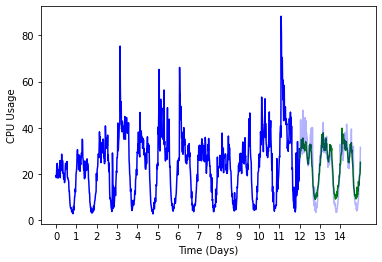

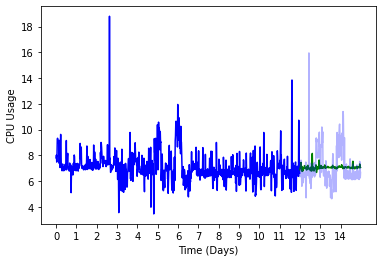

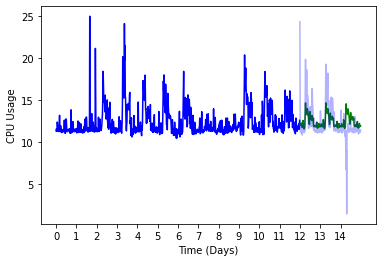

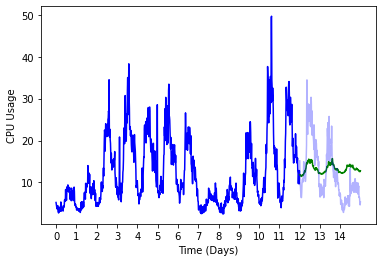

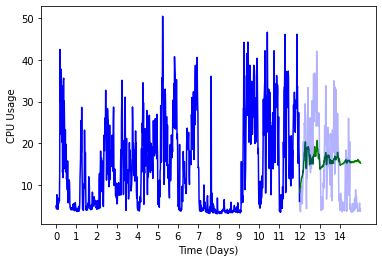

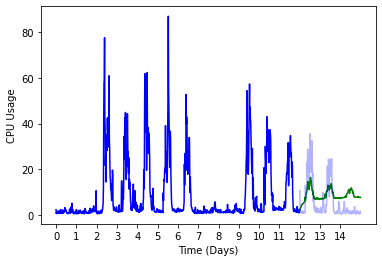

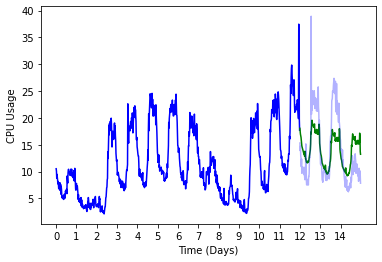

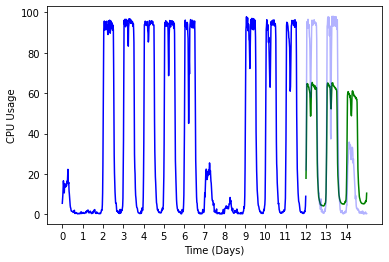

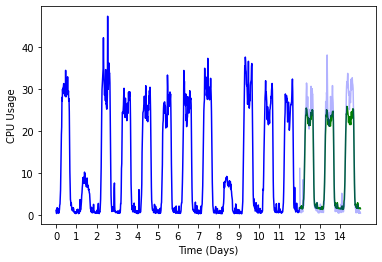

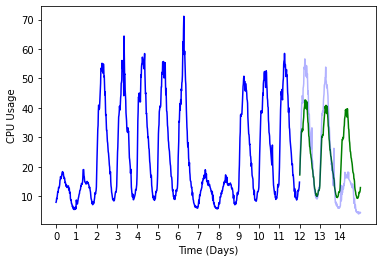

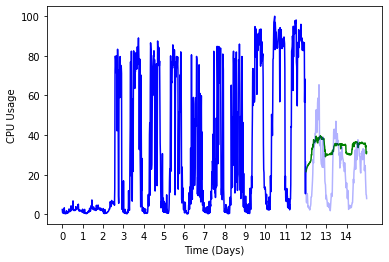

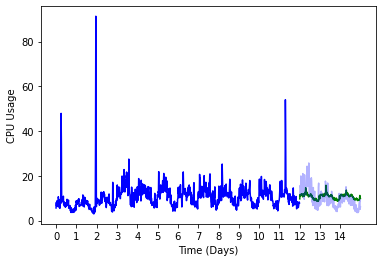

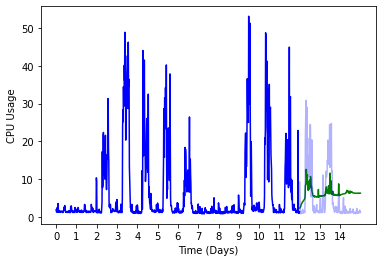

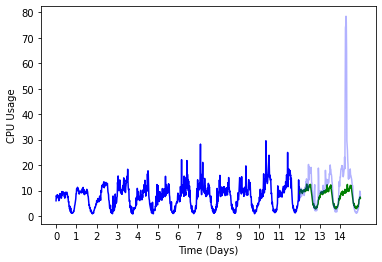

In [96]:
freq = 20
seasonality = (24 * 60) // freq
split = 0.8
p, d, q= (1,0,1)
P, D, Q = (3, 0, 3)

models = {}
datasets = ['WI','KY', 'ND', 'CA', 'DE', 'OK', 'NE', 'MD', 'ID', 'WV', 'NC','WY', 'VT', 'IA']
columns = ['MAE', 'RMSE', 'MAPE', '3pt MAE','3pt RMSE','3pt MAPE', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_MAPE', '3pt MEAN MAE','3pt MEAN RMSE','3pt MEAN MAPE', 'NAIVE_MAE', 'NAIVE_RMSE', 'NAIVE_MAE', '3pt NAIVE MAE','3pt NAIVE RMSE','3pt NAIVE MAPE']
df = pd.DataFrame(columns = columns, dtype=np.float64)
for dataset in datasets:
    print(dataset)
    # Generates train and test sets 
    data = pd.read_csv('samples/' + dataset + '.csv', delimiter=',', index_col=0, parse_dates=True)
    downsampled = data.resample(str(freq) + 'T').mean()
    raw_values = np.asarray(downsampled['CpuUtilizationAverage'])
    train_frac = '2_3'
    tsize = math.floor(raw_values.shape[0] * split)
    train, test = model_selection.train_test_split(raw_values, train_size=tsize)

    #Calculate Naive Values
    mean = train.mean()
    mean_forecasts = np.ones(test.shape[0]) * mean
    naive_forecasts = np.ones(test.shape[0]) * train[-1]
    
    filename = f"./models/{dataset}.arima"
    model = pickle.load(open( filename, "rb" ))
    
    # Predict future
    model_forecasts = model.predict(test.shape[0])
    
    fig, ax = plt.subplots()
    x = np.arange(raw_values.shape[0])
    plt.plot(x[:tsize], train, c='blue')
    plt.plot(x[tsize:], model_forecasts, c='green')
    plt.plot(x[tsize:], raw_values[tsize:], c='blue', alpha=0.3)
    #plt.title(f"CPU Prediction with SARIMA (dataset 
    plt.xlabel('Time (Days)')
    plt.ylabel('CPU Usage')
    ticks = np.arange(0, raw_values.shape[0], seasonality)
    tick_labels = [str(label) for label in ticks // seasonality]
    ax = plt.gca()
    plt.xticks(ticks)
    ax.set_xticklabels(tick_labels)
    plt.draw()
    plotname = f"./arima_plots/{dataset}.png"
    plt.savefig(plotname, format='png')

    # Calculate Errors
    errors = []
    
    for forecast in [model_forecasts, mean_forecasts, naive_forecasts]:
        errors.extend(calculate_errors(forecast, test))
        errors.extend(calculate_errors(forecast[:3], test[:3]))

    row = pd.DataFrame([errors], index=[dataset], columns = columns, dtype=np.float64 )
    df = pd.concat([row, df])

avg_row = df.mean(axis=0).rename('Average', inplace=True)
min_row = df.max(axis=0).rename('Maximum', inplace=True)
max_row = df.min(axis=0).rename('Minimum', inplace = True)
df = df.append(avg_row).append(min_row).append(max_row)




In [98]:
columns = ['MAE', 'MAPE', 'MEAN_MAE', 'MEAN_MAPE']
df1 = df[columns]
df1.to_csv("arima_results1.csv", float_format="%.2f")


In [99]:
columns = ['3pt MAE','3pt MAPE', '3pt MEAN MAE','3pt MEAN MAPE']
df2 = df[columns]
df2.to_csv("arima_results2.csv", float_format="%.2f")
